# Import Library yang Digunakan

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswarm import pso
from tqdm import tqdm
import pickle

# Data Overview

In [175]:
# from google.colab import drive

# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/TA/aqi_jakarta_data.csv'

In [176]:
df = pd.read_csv('aqi_jakarta_data.csv')

In [177]:
df.head()

,Date,City,Country,Status,AQI_Value
0,6/3/2022,Jakarta,Indonesia,Moderate,79.0
1,6/4/2022,Jakarta,Indonesia,Moderate,99.0
2,6/5/2022,Jakarta,Indonesia,Unhealthy for Sensitive Groups,122.0
3,6/6/2022,Jakarta,Indonesia,Unhealthy for Sensitive Groups,126.0
4,6/7/2022,Jakarta,Indonesia,Unhealthy for Sensitive Groups,117.0


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       455 non-null    object 
 1   City       455 non-null    object 
 2   Country    455 non-null    object 
 3   Status     455 non-null    object 
 4   AQI_Value  455 non-null    float64
dtypes: float64(1), object(4)
memory usage: 17.9+ KB


In [179]:
df.isnull().sum()

Date         0
City         0
Country      0
Status       0
AQI_Value    0
dtype: int64

In [180]:
df.describe()

,AQI_Value
count,455.000000
mean,103.123077
std,31.870163
min,28.000000
25%,78.000000
50%,106.000000
75%,130.000000
max,162.000000


# Interpolasi (Data Fixing)

In [181]:
#  METODE INTERPOLASI
from scipy.interpolate import interp1d

indices = ~np.isnan(df['AQI_Value'])
x = np.arange(len(df['AQI_Value']))
x_interp = x[indices]
y_interp = df['AQI_Value'][indices]

interp_func = interp1d(x_interp, y_interp, kind='linear', fill_value='extrapolate')
interpolated_data = interp_func(x)
for i, row in df.iterrows():
    if pd.isna(row['AQI_Value']):
        df.at[i, 'AQI_Value'] = interpolated_data[i]

# print(interpolated_data)
print(df.loc [265:271])

          Date     City    Country    Status  AQI_Value
265  2/23/2023  Jakarta  Indonesia      Good       44.0
266  2/24/2023  Jakarta  Indonesia      Good       45.0
267  2/25/2023  Jakarta  Indonesia      Good       47.0
268  2/26/2023  Jakarta  Indonesia      Good       49.0
269  2/27/2023  Jakarta  Indonesia      Good       51.0
270  2/28/2023  Jakarta  Indonesia  Moderate       53.0
271   3/1/2023  Jakarta  Indonesia  Moderate       55.0


# Min Max Scaling

In [182]:
from sklearn.preprocessing import MinMaxScaler

In [183]:
# Memilih kolom yang ingin dinormalisasi (ganti 'kolom' dengan nama kolom yang sesuai)
kolom = 'AQI_Value'
data_to_scale = df[[kolom]]

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Melakukan Min-Max scaling pada kolom yang dipilih
scaled_data = scaler.fit_transform(data_to_scale)

# Membuat DataFrame baru dengan data yang telah dinormalisasi
data_scaled = pd.DataFrame(scaled_data, columns=[kolom+'_scaled'])

# Gabungkan data yang telah dinormalisasi dengan data asli
data_minmax = pd.concat([df['Date'], data_scaled], axis=1)

# Hasil scaling
print("Data Asli:")
print(df[['Date', 'AQI_Value']])
print("\nData yang Telah Dinormalisasi:")
print(data_minmax)

Data Asli:
          Date  AQI_Value
0     6/3/2022       79.0
1     6/4/2022       99.0
2     6/5/2022      122.0
3     6/6/2022      126.0
4     6/7/2022      117.0
..         ...        ...
450  8/27/2023      102.0
451  8/28/2023      136.0
452  8/29/2023      119.0
453  8/30/2023      131.0
454  8/31/2023      136.0

[455 rows x 2 columns]

Data yang Telah Dinormalisasi:
          Date  AQI_Value_scaled
0     6/3/2022          0.380597
1     6/4/2022          0.529851
2     6/5/2022          0.701493
3     6/6/2022          0.731343
4     6/7/2022          0.664179
..         ...               ...
450  8/27/2023          0.552239
451  8/28/2023          0.805970
452  8/29/2023          0.679104
453  8/30/2023          0.768657
454  8/31/2023          0.805970

[455 rows x 2 columns]


# Data *Splitting*

1. 70:30
2. 80:20
3. 90:10

In [184]:
df1 = data_minmax['AQI_Value_scaled']

In [185]:
# from sklearn.model_selection import train_test_split

# Memisahkan data menjadi data pelatihan dan pengujian dengan perbandingan 70:30
train_size_70 = int(0.7 * len(df1))

# Memisahkan data menjadi data pelatihan dan pengujian dengan perbandingan 80:20
train_size_80 = int(0.8 * len(df1))

# Memisahkan data menjadi data pelatihan dan pengujian dengan perbandingan 90:10
train_size_90 = int(0.9 * len(df1))


# Memisahkan data menjadi data pelatihan dan pengujian
train_70 = df1[:train_size_70]
test_30 = df1[train_size_70:]

train_80 = df1[:train_size_80]
test_20 = df1[train_size_80:]

train_90 = df1[:train_size_90]
test_10 = df1[train_size_90:]

#Double Exponential Smoothing

In [186]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import statsmodels.tsa.holtwinters as sm

from sklearn.metrics import mean_squared_error,mean_absolute_error

##1st Test (70:30)

In [215]:
# Inisialisasi dataset
train_db, test_db = df1[:train_size_70], df1[train_size_70:]

##PSO

In [216]:
# Fungsi tujuan untuk optimasi PSO
def objective(params, *args):
    alpha, beta = params
    train, test = args

    model_holt = ExponentialSmoothing(train, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt = model_holt.fit(smoothing_level=alpha, smoothing_trend=beta)
    pred_test_holt = fit_holt.predict(start=test.index[0], end=test.index[-1])

    # Menghitung Mean Squared Error (MSE) sebagai fungsi tujuan
    mse = mean_squared_error(test, pred_test_holt)

    return mse

# Tentukan batas parameter untuk PSO
lb = [0.01, 0.01]  # Lower bounds for alpha and beta
ub = [0.99, 0.99]  # Upper bounds for alpha and beta

# Inisialisasi list untuk menyimpan nilai objektif, alpha, dan beta selama iterasi
iteration_results = []

# Inisialisasi list untuk menyimpan pergerakan alpha dan beta pada setiap iterasi
alpha_values = []
beta_values = []

# Jalankan PSO untuk mencari parameter terbaik
best_params = None
best_mse = float('inf')  # Set nilai awal yang besar untuk objektif terbaik

for i in tqdm(range(100)):
    current_params, current_mse = pso(objective, lb, ub, args=(train_db, test_db), swarmsize=10, maxiter=1)

    # Simpan hasil iterasi jika nilai objektif lebih baik
    if current_mse < best_mse:
        best_params = current_params
        best_mse = current_mse

    # Simpan hasil iterasi pada list untuk pergerakan alpha dan beta
    alpha_optimal, beta_optimal = best_params
    alpha_values.append(alpha_optimal)
    beta_values.append(beta_optimal)

    model_holt_optimal = ExponentialSmoothing(train_db, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt_optimal = model_holt_optimal.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
    train_mse_score = mean_squared_error(train_db, fit_holt_optimal.fittedvalues)
    test_mse_score = mean_squared_error(test_db, fit_holt_optimal.forecast(len(test_db)))

    iteration_results.append({
        'Iteration': i + 1,
        'Alpha': alpha_optimal,
        'Beta': beta_optimal,
        'Train_MSE': train_mse_score,
        'Test_MSE': test_mse_score
    })

# Tampilkan hasil terbaik
print("Best Parameters:", best_params)

# Tampilkan pergerakan alpha dan beta pada setiap iterasi
for i in range(len(alpha_values)):
    print(f"Iteration {i + 1}: Alpha = {alpha_values[i]}, Beta = {beta_values[i]}")

  2%|▏         | 2/100 [00:00<00:17,  5.65it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


  3%|▎         | 3/100 [00:00<00:22,  4.24it/s]

Stopping search: maximum iterations reached --> 1


  4%|▍         | 4/100 [00:01<00:27,  3.51it/s]

Stopping search: maximum iterations reached --> 1


  5%|▌         | 5/100 [00:01<00:26,  3.60it/s]

Stopping search: maximum iterations reached --> 1


  6%|▌         | 6/100 [00:01<00:25,  3.70it/s]

Stopping search: maximum iterations reached --> 1


  7%|▋         | 7/100 [00:01<00:23,  3.92it/s]

Stopping search: maximum iterations reached --> 1


  8%|▊         | 8/100 [00:02<00:22,  4.00it/s]

Stopping search: maximum iterations reached --> 1


  9%|▉         | 9/100 [00:02<00:22,  4.10it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 11%|█         | 11/100 [00:02<00:20,  4.24it/s]

Stopping search: maximum iterations reached --> 1


 12%|█▏        | 12/100 [00:02<00:22,  3.93it/s]

Stopping search: maximum iterations reached --> 1


 13%|█▎        | 13/100 [00:03<00:22,  3.87it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 15%|█▌        | 15/100 [00:03<00:19,  4.29it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 17%|█▋        | 17/100 [00:04<00:18,  4.58it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 19%|█▉        | 19/100 [00:04<00:17,  4.63it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 21%|██        | 21/100 [00:04<00:16,  4.85it/s]

Stopping search: maximum iterations reached --> 1


 23%|██▎       | 23/100 [00:05<00:15,  4.92it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 24%|██▍       | 24/100 [00:05<00:17,  4.30it/s]

Stopping search: maximum iterations reached --> 1


 25%|██▌       | 25/100 [00:05<00:20,  3.62it/s]

Stopping search: maximum iterations reached --> 1


 26%|██▌       | 26/100 [00:06<00:20,  3.57it/s]

Stopping search: maximum iterations reached --> 1


 27%|██▋       | 27/100 [00:06<00:20,  3.57it/s]

Stopping search: maximum iterations reached --> 1


 28%|██▊       | 28/100 [00:06<00:20,  3.51it/s]

Stopping search: maximum iterations reached --> 1


 29%|██▉       | 29/100 [00:07<00:19,  3.55it/s]

Stopping search: maximum iterations reached --> 1


 30%|███       | 30/100 [00:07<00:20,  3.47it/s]

Stopping search: maximum iterations reached --> 1


 31%|███       | 31/100 [00:07<00:20,  3.44it/s]

Stopping search: maximum iterations reached --> 1


 32%|███▏      | 32/100 [00:08<00:20,  3.38it/s]

Stopping search: maximum iterations reached --> 1


 33%|███▎      | 33/100 [00:08<00:19,  3.46it/s]

Stopping search: maximum iterations reached --> 1


 34%|███▍      | 34/100 [00:08<00:18,  3.54it/s]

Stopping search: maximum iterations reached --> 1


 35%|███▌      | 35/100 [00:08<00:19,  3.41it/s]

Stopping search: maximum iterations reached --> 1


 36%|███▌      | 36/100 [00:09<00:18,  3.42it/s]

Stopping search: maximum iterations reached --> 1


 37%|███▋      | 37/100 [00:09<00:17,  3.54it/s]

Stopping search: maximum iterations reached --> 1


 38%|███▊      | 38/100 [00:09<00:17,  3.45it/s]

Stopping search: maximum iterations reached --> 1


 39%|███▉      | 39/100 [00:10<00:17,  3.59it/s]

Stopping search: maximum iterations reached --> 1


 40%|████      | 40/100 [00:10<00:16,  3.58it/s]

Stopping search: maximum iterations reached --> 1


 41%|████      | 41/100 [00:10<00:15,  3.71it/s]

Stopping search: maximum iterations reached --> 1


 42%|████▏     | 42/100 [00:11<00:20,  2.82it/s]

Stopping search: maximum iterations reached --> 1


 43%|████▎     | 43/100 [00:11<00:21,  2.65it/s]

Stopping search: maximum iterations reached --> 1


 44%|████▍     | 44/100 [00:11<00:21,  2.60it/s]

Stopping search: maximum iterations reached --> 1


 45%|████▌     | 45/100 [00:12<00:20,  2.70it/s]

Stopping search: maximum iterations reached --> 1


 46%|████▌     | 46/100 [00:12<00:19,  2.79it/s]

Stopping search: maximum iterations reached --> 1


 47%|████▋     | 47/100 [00:12<00:19,  2.77it/s]

Stopping search: maximum iterations reached --> 1


 48%|████▊     | 48/100 [00:13<00:18,  2.75it/s]

Stopping search: maximum iterations reached --> 1


 49%|████▉     | 49/100 [00:13<00:18,  2.72it/s]

Stopping search: maximum iterations reached --> 1


 50%|█████     | 50/100 [00:14<00:18,  2.70it/s]

Stopping search: maximum iterations reached --> 1


 51%|█████     | 51/100 [00:14<00:17,  2.77it/s]

Stopping search: maximum iterations reached --> 1


 52%|█████▏    | 52/100 [00:14<00:17,  2.75it/s]

Stopping search: maximum iterations reached --> 1


 53%|█████▎    | 53/100 [00:15<00:16,  2.79it/s]

Stopping search: maximum iterations reached --> 1


 54%|█████▍    | 54/100 [00:15<00:16,  2.81it/s]

Stopping search: maximum iterations reached --> 1


 55%|█████▌    | 55/100 [00:15<00:15,  2.88it/s]

Stopping search: maximum iterations reached --> 1


 56%|█████▌    | 56/100 [00:16<00:15,  2.84it/s]

Stopping search: maximum iterations reached --> 1


 57%|█████▋    | 57/100 [00:16<00:14,  2.87it/s]

Stopping search: maximum iterations reached --> 1


 58%|█████▊    | 58/100 [00:16<00:14,  2.89it/s]

Stopping search: maximum iterations reached --> 1


 59%|█████▉    | 59/100 [00:17<00:13,  2.94it/s]

Stopping search: maximum iterations reached --> 1


 60%|██████    | 60/100 [00:17<00:13,  2.91it/s]

Stopping search: maximum iterations reached --> 1


 61%|██████    | 61/100 [00:17<00:12,  3.08it/s]

Stopping search: maximum iterations reached --> 1


 62%|██████▏   | 62/100 [00:18<00:12,  3.14it/s]

Stopping search: maximum iterations reached --> 1


 63%|██████▎   | 63/100 [00:18<00:13,  2.83it/s]

Stopping search: maximum iterations reached --> 1


 64%|██████▍   | 64/100 [00:18<00:12,  2.98it/s]

Stopping search: maximum iterations reached --> 1


 65%|██████▌   | 65/100 [00:19<00:11,  3.05it/s]

Stopping search: maximum iterations reached --> 1


 66%|██████▌   | 66/100 [00:19<00:11,  2.98it/s]

Stopping search: maximum iterations reached --> 1


 67%|██████▋   | 67/100 [00:19<00:11,  2.90it/s]

Stopping search: maximum iterations reached --> 1


 68%|██████▊   | 68/100 [00:20<00:11,  2.91it/s]

Stopping search: maximum iterations reached --> 1


 69%|██████▉   | 69/100 [00:20<00:10,  2.95it/s]

Stopping search: maximum iterations reached --> 1


 70%|███████   | 70/100 [00:20<00:09,  3.14it/s]

Stopping search: maximum iterations reached --> 1


 71%|███████   | 71/100 [00:21<00:09,  3.11it/s]

Stopping search: maximum iterations reached --> 1


 72%|███████▏  | 72/100 [00:21<00:08,  3.24it/s]

Stopping search: maximum iterations reached --> 1


 73%|███████▎  | 73/100 [00:21<00:08,  3.21it/s]

Stopping search: maximum iterations reached --> 1


 74%|███████▍  | 74/100 [00:22<00:08,  3.22it/s]

Stopping search: maximum iterations reached --> 1


 75%|███████▌  | 75/100 [00:22<00:07,  3.25it/s]

Stopping search: maximum iterations reached --> 1


 76%|███████▌  | 76/100 [00:22<00:07,  3.28it/s]

Stopping search: maximum iterations reached --> 1


 77%|███████▋  | 77/100 [00:22<00:06,  3.37it/s]

Stopping search: maximum iterations reached --> 1


 78%|███████▊  | 78/100 [00:23<00:06,  3.45it/s]

Stopping search: maximum iterations reached --> 1


 79%|███████▉  | 79/100 [00:23<00:06,  3.43it/s]

Stopping search: maximum iterations reached --> 1


 80%|████████  | 80/100 [00:23<00:05,  3.47it/s]

Stopping search: maximum iterations reached --> 1


 81%|████████  | 81/100 [00:24<00:05,  3.50it/s]

Stopping search: maximum iterations reached --> 1


 82%|████████▏ | 82/100 [00:24<00:05,  3.39it/s]

Stopping search: maximum iterations reached --> 1


 83%|████████▎ | 83/100 [00:24<00:04,  3.45it/s]

Stopping search: maximum iterations reached --> 1


 84%|████████▍ | 84/100 [00:24<00:04,  3.46it/s]

Stopping search: maximum iterations reached --> 1


 85%|████████▌ | 85/100 [00:25<00:04,  3.49it/s]

Stopping search: maximum iterations reached --> 1


 86%|████████▌ | 86/100 [00:25<00:04,  3.40it/s]

Stopping search: maximum iterations reached --> 1


 87%|████████▋ | 87/100 [00:25<00:04,  3.18it/s]

Stopping search: maximum iterations reached --> 1


 88%|████████▊ | 88/100 [00:26<00:03,  3.18it/s]

Stopping search: maximum iterations reached --> 1


 89%|████████▉ | 89/100 [00:26<00:03,  2.90it/s]

Stopping search: maximum iterations reached --> 1


 90%|█████████ | 90/100 [00:26<00:03,  2.94it/s]

Stopping search: maximum iterations reached --> 1


 91%|█████████ | 91/100 [00:27<00:03,  2.79it/s]

Stopping search: maximum iterations reached --> 1


 92%|█████████▏| 92/100 [00:27<00:02,  2.73it/s]

Stopping search: maximum iterations reached --> 1


 93%|█████████▎| 93/100 [00:28<00:02,  2.69it/s]

Stopping search: maximum iterations reached --> 1


 94%|█████████▍| 94/100 [00:28<00:02,  2.68it/s]

Stopping search: maximum iterations reached --> 1


 95%|█████████▌| 95/100 [00:28<00:01,  2.79it/s]

Stopping search: maximum iterations reached --> 1


 96%|█████████▌| 96/100 [00:29<00:01,  2.94it/s]

Stopping search: maximum iterations reached --> 1


 97%|█████████▋| 97/100 [00:29<00:01,  2.95it/s]

Stopping search: maximum iterations reached --> 1


 98%|█████████▊| 98/100 [00:29<00:00,  3.15it/s]

Stopping search: maximum iterations reached --> 1


 99%|█████████▉| 99/100 [00:29<00:00,  3.33it/s]

Stopping search: maximum iterations reached --> 1


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]

Stopping search: maximum iterations reached --> 1
Best Parameters: [0.01       0.79141525]
Iteration 1: Alpha = 0.3572668961669333, Beta = 0.27742152211054844
Iteration 2: Alpha = 0.8306215071380697, Beta = 0.020450824578806474
Iteration 3: Alpha = 0.8306215071380697, Beta = 0.020450824578806474
Iteration 4: Alpha = 0.8306215071380697, Beta = 0.020450824578806474
Iteration 5: Alpha = 0.8306215071380697, Beta = 0.020450824578806474
Iteration 6: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 7: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 8: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 9: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 10: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 11: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 12: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration 13: Alpha = 0.8902642469872635, Beta = 0.019687836396343528
Iteration

##Method Implementation

In [217]:
alpha_optimal, beta_optimal = best_paramsalpha_optimal, beta_optimal = best_params

double_exp = sm.ExponentialSmoothing(train_db, trend='add', initialization_method='estimated', seasonal=None, damped_trend = False)
double_exp_fit = double_exp.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
double_exp_train_pred = double_exp_fit.predict(start=train_db.index[0], end=train_db.index[-1])
double_exp_test_pred = double_exp_fit.predict(start=test_db.index[0], end=test_db.index[-1])

# Menghitung Evaluasi Model untuk data pelatihan
train_mae_score = mean_absolute_error(train_db, double_exp_train_pred)
train_rmse_score = (mean_squared_error(train_db, double_exp_train_pred)**0.5)

# Menghitung Evaluasi Model untuk data pengujian
test_mae_score = mean_absolute_error(test_db, double_exp_test_pred)
test_rmse_score = (mean_squared_error(test_db, double_exp_test_pred)**0.5)

print('Train Root Mean Squared Error (RMSE):', train_rmse_score)
print('Train Mean Absolute Error (MAE):', train_mae_score)
print('Test Root Mean Squared Error (RMSE):', test_rmse_score)
print('Test Mean Absolute Error (MAE):', test_mae_score)

# Mengakses nilai parameter smoothing level dan smoothing tren untuk data pelatihan
smoothing_level_train = double_exp_fit.params['smoothing_level']
smoothing_trend_train = double_exp_fit.params['smoothing_trend']

print("Alpha : ", round(smoothing_level_train, 5))
print("Beta : ", round(smoothing_trend_train, 5))

Train Root Mean Squared Error (RMSE): 0.19679235718316768
Train Mean Absolute Error (MAE): 0.15850388980926833
Test Root Mean Squared Error (RMSE): 0.1507958785161076
Test Mean Absolute Error (MAE): 0.12262028723884529
Alpha :  0.01
Beta :  0.79142


In [218]:
#Denormalisasi data untuk menghasilkan nilai yang aktual
train_db_array = train_db.values.reshape(-1, 1)
test_db_array = test_db.values.reshape(-1, 1)
pred_array = double_exp_test_pred.values.reshape(-1, 1)

# Now you can use test_db_array in your scaler.inverse_transform call
train_db_scaler = scaler.inverse_transform(train_db_array)
test_db_scaler = scaler.inverse_transform(test_db_array)
pred_scaler = scaler.inverse_transform(pred_array)

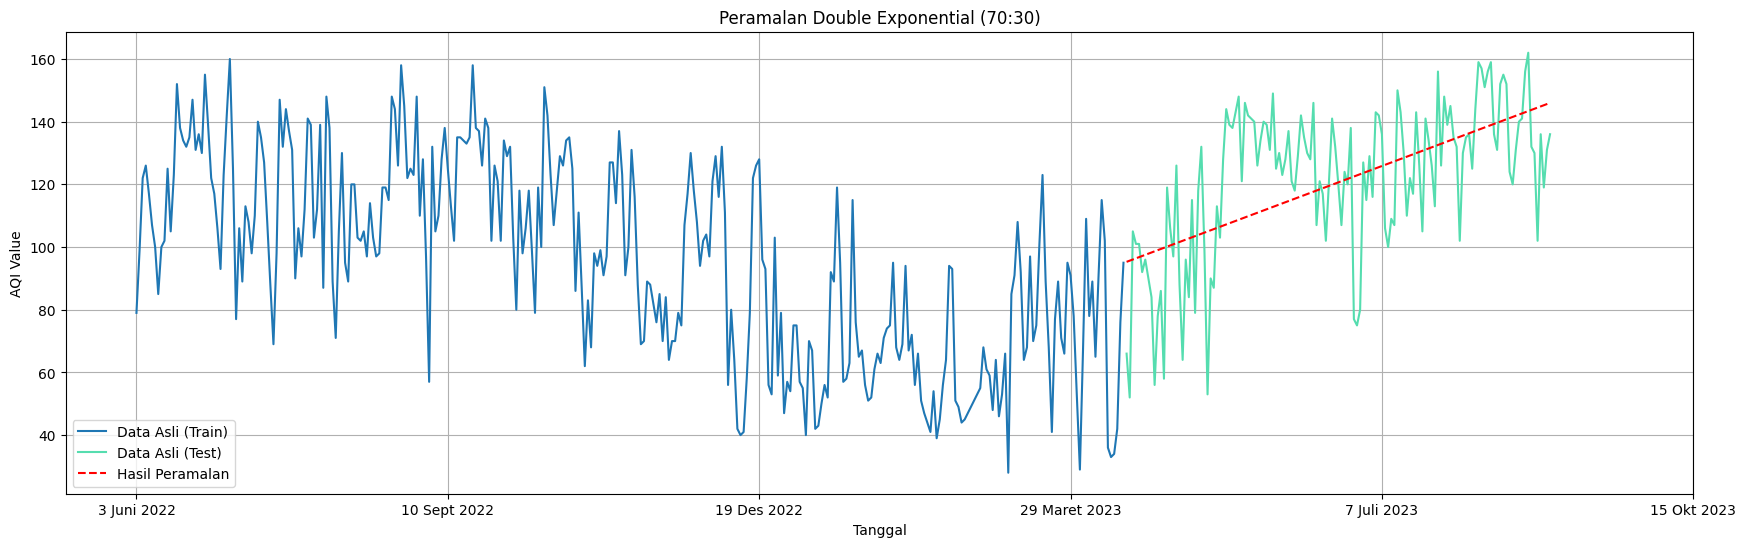

In [219]:
# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(21, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(train_db)], train_db_scaler, label='Data Asli (Train)')
plt.plot(df['Date'][-len(test_db):], test_db_scaler, label='Data Asli (Test)', color = '#55DDAF')
plt.plot(df['Date'][-len(test_db):], pred_scaler, label='Hasil Peramalan', color ='red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Double Exponential (70:30)')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

##2nd Test (80:20)

In [225]:
train_db, test_db = df1[:train_size_80], df1[train_size_80:]

##PSO

In [230]:
# Fungsi tujuan untuk optimasi PSO
def objective(params, *args):
    alpha, beta = params
    train, test = args

    model_holt = ExponentialSmoothing(train, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt = model_holt.fit(smoothing_level=alpha, smoothing_trend=beta)
    pred_test_holt = fit_holt.predict(start=test.index[0], end=test.index[-1])

    # Menghitung Mean Squared Error (MSE) sebagai fungsi tujuan
    mse = mean_squared_error(test, pred_test_holt)

    return mse

# Tentukan batas parameter untuk PSO
lb = [0.01, 0.01]  # Lower bounds for alpha and beta
ub = [0.99, 0.99]  # Upper bounds for alpha and beta

# Inisialisasi list untuk menyimpan nilai objektif, alpha, dan beta selama iterasi
iteration_results = []

# Inisialisasi list untuk menyimpan pergerakan alpha dan beta pada setiap iterasi
alpha_values = []
beta_values = []

# Jalankan PSO untuk mencari parameter terbaik
best_params = None
best_mse = float('inf')  # Set nilai awal yang besar untuk objektif terbaik

for i in tqdm(range(100)):
    current_params, current_mse = pso(objective, lb, ub, args=(train_db, test_db), swarmsize=10, maxiter=1)

    # Simpan hasil iterasi jika nilai objektif lebih baik
    if current_mse < best_mse:
        best_params = current_params
        best_mse = current_mse

    # Simpan hasil iterasi pada list untuk pergerakan alpha dan beta
    alpha_optimal, beta_optimal = best_params
    alpha_values.append(alpha_optimal)
    beta_values.append(beta_optimal)

    model_holt_optimal = ExponentialSmoothing(train_db, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt_optimal = model_holt_optimal.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
    train_mse_score = mean_squared_error(train_db, fit_holt_optimal.fittedvalues)
    test_mse_score = mean_squared_error(test_db, fit_holt_optimal.forecast(len(test_db)))

    iteration_results.append({
        'Iteration': i + 1,
        'Alpha': alpha_optimal,
        'Beta': beta_optimal,
        'Train_MSE': train_mse_score,
        'Test_MSE': test_mse_score
    })

# Tampilkan hasil terbaik
print("Best Parameters:", best_params)

# Tampilkan pergerakan alpha dan beta pada setiap iterasi
for i in range(len(alpha_values)):
    print(f"Iteration {i + 1}: Alpha = {alpha_values[i]}, Beta = {beta_values[i]}")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:27,  3.55it/s]

Stopping search: maximum iterations reached --> 1


  2%|▏         | 2/100 [00:00<00:27,  3.60it/s]

Stopping search: maximum iterations reached --> 1


  3%|▎         | 3/100 [00:01<00:34,  2.81it/s]

Stopping search: maximum iterations reached --> 1


  4%|▍         | 4/100 [00:01<00:45,  2.10it/s]

Stopping search: maximum iterations reached --> 1


  5%|▌         | 5/100 [00:02<00:43,  2.18it/s]

Stopping search: maximum iterations reached --> 1


  6%|▌         | 6/100 [00:02<00:41,  2.27it/s]

Stopping search: maximum iterations reached --> 1


  7%|▋         | 7/100 [00:02<00:39,  2.37it/s]

Stopping search: maximum iterations reached --> 1


  8%|▊         | 8/100 [00:03<00:37,  2.45it/s]

Stopping search: maximum iterations reached --> 1


  9%|▉         | 9/100 [00:03<00:37,  2.43it/s]

Stopping search: maximum iterations reached --> 1


 10%|█         | 10/100 [00:04<00:39,  2.26it/s]

Stopping search: maximum iterations reached --> 1


 11%|█         | 11/100 [00:04<00:36,  2.42it/s]

Stopping search: maximum iterations reached --> 1


 12%|█▏        | 12/100 [00:04<00:33,  2.62it/s]

Stopping search: maximum iterations reached --> 1


 13%|█▎        | 13/100 [00:05<00:31,  2.78it/s]

Stopping search: maximum iterations reached --> 1


 14%|█▍        | 14/100 [00:05<00:29,  2.88it/s]

Stopping search: maximum iterations reached --> 1


 15%|█▌        | 15/100 [00:05<00:27,  3.06it/s]

Stopping search: maximum iterations reached --> 1


 16%|█▌        | 16/100 [00:06<00:26,  3.14it/s]

Stopping search: maximum iterations reached --> 1


 17%|█▋        | 17/100 [00:06<00:25,  3.22it/s]

Stopping search: maximum iterations reached --> 1


 18%|█▊        | 18/100 [00:06<00:26,  3.04it/s]

Stopping search: maximum iterations reached --> 1


 19%|█▉        | 19/100 [00:07<00:29,  2.72it/s]

Stopping search: maximum iterations reached --> 1


 20%|██        | 20/100 [00:07<00:31,  2.58it/s]

Stopping search: maximum iterations reached --> 1


 21%|██        | 21/100 [00:07<00:29,  2.68it/s]

Stopping search: maximum iterations reached --> 1


 22%|██▏       | 22/100 [00:08<00:27,  2.84it/s]

Stopping search: maximum iterations reached --> 1


 23%|██▎       | 23/100 [00:08<00:26,  2.94it/s]

Stopping search: maximum iterations reached --> 1


 24%|██▍       | 24/100 [00:08<00:24,  3.11it/s]

Stopping search: maximum iterations reached --> 1


 25%|██▌       | 25/100 [00:09<00:25,  2.96it/s]

Stopping search: maximum iterations reached --> 1


 26%|██▌       | 26/100 [00:09<00:24,  3.00it/s]

Stopping search: maximum iterations reached --> 1


 27%|██▋       | 27/100 [00:09<00:24,  3.04it/s]

Stopping search: maximum iterations reached --> 1


 28%|██▊       | 28/100 [00:10<00:22,  3.14it/s]

Stopping search: maximum iterations reached --> 1


 29%|██▉       | 29/100 [00:10<00:21,  3.24it/s]

Stopping search: maximum iterations reached --> 1


 30%|███       | 30/100 [00:10<00:21,  3.21it/s]

Stopping search: maximum iterations reached --> 1


 31%|███       | 31/100 [00:11<00:20,  3.29it/s]

Stopping search: maximum iterations reached --> 1


 32%|███▏      | 32/100 [00:11<00:19,  3.41it/s]

Stopping search: maximum iterations reached --> 1


 33%|███▎      | 33/100 [00:11<00:19,  3.41it/s]

Stopping search: maximum iterations reached --> 1


 34%|███▍      | 34/100 [00:11<00:19,  3.36it/s]

Stopping search: maximum iterations reached --> 1


 35%|███▌      | 35/100 [00:12<00:22,  2.91it/s]

Stopping search: maximum iterations reached --> 1


 36%|███▌      | 36/100 [00:12<00:26,  2.38it/s]

Stopping search: maximum iterations reached --> 1


 37%|███▋      | 37/100 [00:13<00:27,  2.25it/s]

Stopping search: maximum iterations reached --> 1


 38%|███▊      | 38/100 [00:13<00:26,  2.32it/s]

Stopping search: maximum iterations reached --> 1


 39%|███▉      | 39/100 [00:14<00:25,  2.36it/s]

Stopping search: maximum iterations reached --> 1


 40%|████      | 40/100 [00:14<00:24,  2.42it/s]

Stopping search: maximum iterations reached --> 1


 41%|████      | 41/100 [00:15<00:27,  2.12it/s]

Stopping search: maximum iterations reached --> 1


 42%|████▏     | 42/100 [00:15<00:27,  2.08it/s]

Stopping search: maximum iterations reached --> 1


 43%|████▎     | 43/100 [00:16<00:28,  2.01it/s]

Stopping search: maximum iterations reached --> 1


 44%|████▍     | 44/100 [00:16<00:27,  2.01it/s]

Stopping search: maximum iterations reached --> 1


 45%|████▌     | 45/100 [00:17<00:27,  2.02it/s]

Stopping search: maximum iterations reached --> 1


 46%|████▌     | 46/100 [00:17<00:25,  2.13it/s]

Stopping search: maximum iterations reached --> 1


 47%|████▋     | 47/100 [00:18<00:23,  2.24it/s]

Stopping search: maximum iterations reached --> 1


 48%|████▊     | 48/100 [00:18<00:23,  2.25it/s]

Stopping search: maximum iterations reached --> 1


 49%|████▉     | 49/100 [00:19<00:23,  2.17it/s]

Stopping search: maximum iterations reached --> 1


 50%|█████     | 50/100 [00:19<00:23,  2.08it/s]

Stopping search: maximum iterations reached --> 1


 51%|█████     | 51/100 [00:20<00:23,  2.05it/s]

Stopping search: maximum iterations reached --> 1


 52%|█████▏    | 52/100 [00:20<00:23,  2.05it/s]

Stopping search: maximum iterations reached --> 1


 53%|█████▎    | 53/100 [00:21<00:22,  2.05it/s]

Stopping search: maximum iterations reached --> 1


 54%|█████▍    | 54/100 [00:21<00:21,  2.09it/s]

Stopping search: maximum iterations reached --> 1


 55%|█████▌    | 55/100 [00:21<00:21,  2.10it/s]

Stopping search: maximum iterations reached --> 1


 56%|█████▌    | 56/100 [00:22<00:20,  2.18it/s]

Stopping search: maximum iterations reached --> 1


 57%|█████▋    | 57/100 [00:22<00:18,  2.31it/s]

Stopping search: maximum iterations reached --> 1


 58%|█████▊    | 58/100 [00:23<00:17,  2.43it/s]

Stopping search: maximum iterations reached --> 1


 59%|█████▉    | 59/100 [00:23<00:16,  2.47it/s]

Stopping search: maximum iterations reached --> 1


 60%|██████    | 60/100 [00:23<00:15,  2.53it/s]

Stopping search: maximum iterations reached --> 1


 61%|██████    | 61/100 [00:24<00:15,  2.57it/s]

Stopping search: maximum iterations reached --> 1


 62%|██████▏   | 62/100 [00:24<00:14,  2.61it/s]

Stopping search: maximum iterations reached --> 1


 63%|██████▎   | 63/100 [00:25<00:14,  2.56it/s]

Stopping search: maximum iterations reached --> 1


 64%|██████▍   | 64/100 [00:25<00:14,  2.56it/s]

Stopping search: maximum iterations reached --> 1


 65%|██████▌   | 65/100 [00:25<00:13,  2.53it/s]

Stopping search: maximum iterations reached --> 1


 66%|██████▌   | 66/100 [00:26<00:13,  2.61it/s]

Stopping search: maximum iterations reached --> 1


 67%|██████▋   | 67/100 [00:26<00:13,  2.54it/s]

Stopping search: maximum iterations reached --> 1


 68%|██████▊   | 68/100 [00:26<00:12,  2.59it/s]

Stopping search: maximum iterations reached --> 1


 69%|██████▉   | 69/100 [00:27<00:11,  2.64it/s]

Stopping search: maximum iterations reached --> 1


 70%|███████   | 70/100 [00:27<00:11,  2.52it/s]

Stopping search: maximum iterations reached --> 1


 71%|███████   | 71/100 [00:28<00:10,  2.65it/s]

Stopping search: maximum iterations reached --> 1


 72%|███████▏  | 72/100 [00:28<00:10,  2.65it/s]

Stopping search: maximum iterations reached --> 1


 73%|███████▎  | 73/100 [00:28<00:10,  2.69it/s]

Stopping search: maximum iterations reached --> 1


 74%|███████▍  | 74/100 [00:29<00:09,  2.71it/s]

Stopping search: maximum iterations reached --> 1


 75%|███████▌  | 75/100 [00:29<00:09,  2.68it/s]

Stopping search: maximum iterations reached --> 1


 76%|███████▌  | 76/100 [00:29<00:08,  2.71it/s]

Stopping search: maximum iterations reached --> 1


 77%|███████▋  | 77/100 [00:30<00:08,  2.67it/s]

Stopping search: maximum iterations reached --> 1


 78%|███████▊  | 78/100 [00:30<00:08,  2.55it/s]

Stopping search: maximum iterations reached --> 1


 79%|███████▉  | 79/100 [00:31<00:08,  2.55it/s]

Stopping search: maximum iterations reached --> 1


 80%|████████  | 80/100 [00:31<00:07,  2.51it/s]

Stopping search: maximum iterations reached --> 1


 81%|████████  | 81/100 [00:31<00:07,  2.57it/s]

Stopping search: maximum iterations reached --> 1


 82%|████████▏ | 82/100 [00:32<00:07,  2.45it/s]

Stopping search: maximum iterations reached --> 1


 83%|████████▎ | 83/100 [00:32<00:07,  2.38it/s]

Stopping search: maximum iterations reached --> 1


 84%|████████▍ | 84/100 [00:33<00:06,  2.37it/s]

Stopping search: maximum iterations reached --> 1


 85%|████████▌ | 85/100 [00:33<00:06,  2.27it/s]

Stopping search: maximum iterations reached --> 1


 86%|████████▌ | 86/100 [00:34<00:06,  2.28it/s]

Stopping search: maximum iterations reached --> 1


 87%|████████▋ | 87/100 [00:34<00:05,  2.32it/s]

Stopping search: maximum iterations reached --> 1


 88%|████████▊ | 88/100 [00:34<00:04,  2.50it/s]

Stopping search: maximum iterations reached --> 1


 89%|████████▉ | 89/100 [00:35<00:04,  2.41it/s]

Stopping search: maximum iterations reached --> 1


 90%|█████████ | 90/100 [00:35<00:03,  2.62it/s]

Stopping search: maximum iterations reached --> 1


 91%|█████████ | 91/100 [00:36<00:03,  2.71it/s]

Stopping search: maximum iterations reached --> 1


 92%|█████████▏| 92/100 [00:36<00:02,  2.81it/s]

Stopping search: maximum iterations reached --> 1


 93%|█████████▎| 93/100 [00:36<00:02,  2.89it/s]

Stopping search: maximum iterations reached --> 1


 94%|█████████▍| 94/100 [00:37<00:02,  2.80it/s]

Stopping search: maximum iterations reached --> 1


 95%|█████████▌| 95/100 [00:37<00:01,  2.92it/s]

Stopping search: maximum iterations reached --> 1


 96%|█████████▌| 96/100 [00:37<00:01,  2.89it/s]

Stopping search: maximum iterations reached --> 1


 97%|█████████▋| 97/100 [00:38<00:01,  2.98it/s]

Stopping search: maximum iterations reached --> 1


 98%|█████████▊| 98/100 [00:38<00:00,  2.90it/s]

Stopping search: maximum iterations reached --> 1


 99%|█████████▉| 99/100 [00:38<00:00,  2.89it/s]

Stopping search: maximum iterations reached --> 1


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]

Stopping search: maximum iterations reached --> 1
Best Parameters: [0.18810691 0.88537984]
Iteration 1: Alpha = 0.9225743525562922, Beta = 0.962204181651715
Iteration 2: Alpha = 0.5020357942363012, Beta = 0.2302506822086427
Iteration 3: Alpha = 0.5020357942363012, Beta = 0.2302506822086427
Iteration 4: Alpha = 0.5020357942363012, Beta = 0.2302506822086427
Iteration 5: Alpha = 0.26843130634467166, Beta = 0.6345595603572709
Iteration 6: Alpha = 0.3601217356370361, Beta = 0.1965243608548388
Iteration 7: Alpha = 0.44663987272483585, Beta = 0.22323843706886892
Iteration 8: Alpha = 0.44663987272483585, Beta = 0.22323843706886892
Iteration 9: Alpha = 0.44663987272483585, Beta = 0.22323843706886892
Iteration 10: Alpha = 0.44360792692203654, Beta = 0.3315537059031328
Iteration 11: Alpha = 0.44360792692203654, Beta = 0.3315537059031328
Iteration 12: Alpha = 0.44360792692203654, Beta = 0.3315537059031328
Iteration 13: Alpha = 0.44360792692203654, Beta = 0.3315537059031328
Iteration 14: Alpha = 0.

##Method Implementation

In [231]:
alpha_optimal, beta_optimal = best_paramsalpha_optimal, beta_optimal = best_params

double_exp = sm.ExponentialSmoothing(train_db, trend='add', initialization_method='estimated', seasonal=None, damped_trend = False)
double_exp_fit = double_exp.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
double_exp_train_pred = double_exp_fit.predict(start=train_db.index[0], end=train_db.index[-1])
double_exp_test_pred = double_exp_fit.predict(start=test_db.index[0], end=test_db.index[-1])

# Menghitung Evaluasi Model untuk data pelatihan
train_mae_score = mean_absolute_error(train_db, double_exp_train_pred)
train_rmse_score = (mean_squared_error(train_db, double_exp_train_pred)**0.5)

# Menghitung Evaluasi Model untuk data pengujian
test_mae_score = mean_absolute_error(test_db, double_exp_test_pred)
test_rmse_score = (mean_squared_error(test_db, double_exp_test_pred)**0.5)

print('Train Root Mean Squared Error (RMSE):', train_rmse_score)
print('Train Mean Absolute Error (MAE):', train_mae_score)
print('Test Root Mean Squared Error (RMSE):', test_rmse_score)
print('Test Mean Absolute Error (MAE):', test_mae_score)

# Mengakses nilai parameter smoothing level dan smoothing tren untuk data pelatihan
smoothing_level_train = double_exp_fit.params['smoothing_level']
smoothing_trend_train = double_exp_fit.params['smoothing_trend']

print("Alpha : ", round(smoothing_level_train, 5))
print("Beta : ", round(smoothing_trend_train, 5))

Train Root Mean Squared Error (RMSE): 0.21506020232177167
Train Mean Absolute Error (MAE): 0.16817765104935198
Test Root Mean Squared Error (RMSE): 0.12628955932469552
Test Mean Absolute Error (MAE): 0.09665998518459314
Alpha :  0.18811
Beta :  0.88538


In [232]:
#Denormalisasi data untuk menghasilkan nilai yang aktual
train_db_array = train_db.values.reshape(-1, 1)
test_db_array = test_db.values.reshape(-1, 1)
pred_array = double_exp_test_pred.values.reshape(-1, 1)

# Now you can use test_db_array in your scaler.inverse_transform call
train_db_scaler = scaler.inverse_transform(train_db_array)
test_db_scaler = scaler.inverse_transform(test_db_array)
pred_scaler = scaler.inverse_transform(pred_array)

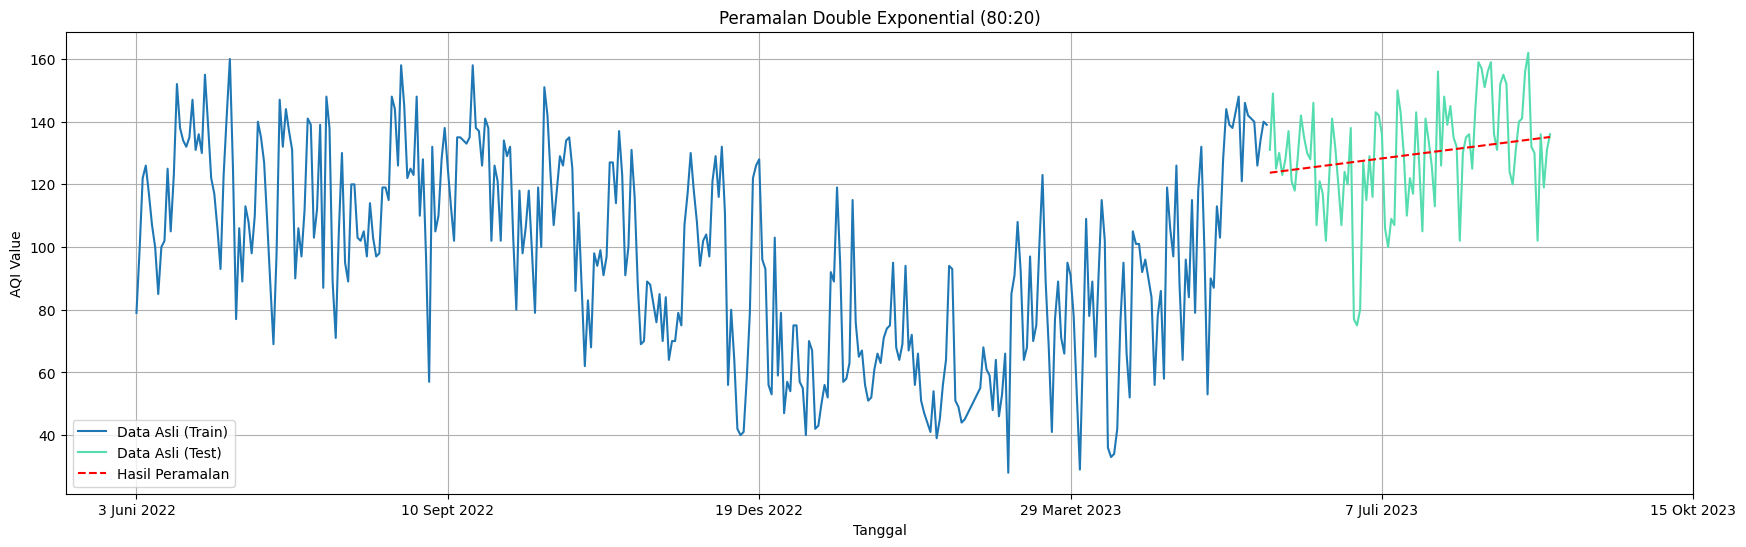

In [234]:
# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(21, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(train_db)], train_db_scaler, label='Data Asli (Train)')
plt.plot(df['Date'][-len(test_db):], test_db_scaler, label='Data Asli (Test)', color = '#55DDAF')
plt.plot(df['Date'][-len(test_db):], pred_scaler, label='Hasil Peramalan', color ='red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Double Exponential (80:20)')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

##3rd Test (90:10)

PSO in Double Exponential Smoothing

In [207]:
train_db, test_db = df1[:train_size_90], df1[train_size_90:]

##PSO

In [210]:
# Fungsi tujuan untuk optimasi PSO
def objective(params, *args):
    alpha, beta = params
    train, test = args

    model_holt = ExponentialSmoothing(train, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt = model_holt.fit(smoothing_level=alpha, smoothing_trend=beta)
    pred_test_holt = fit_holt.predict(start=test.index[0], end=test.index[-1])

    # Menghitung Mean Squared Error (MSE) sebagai fungsi tujuan
    mse = mean_squared_error(test, pred_test_holt)

    return mse

# Tentukan batas parameter untuk PSO
lb = [0.01, 0.01]  # Lower bounds for alpha and beta
ub = [0.99, 0.99]  # Upper bounds for alpha and beta

# Inisialisasi list untuk menyimpan nilai objektif, alpha, dan beta selama iterasi
iteration_results = []

# Inisialisasi list untuk menyimpan pergerakan alpha dan beta pada setiap iterasi
alpha_values = []
beta_values = []

# Jalankan PSO untuk mencari parameter terbaik
best_params = None
best_mse = float('inf')  # Set nilai awal yang besar untuk objektif terbaik

for i in tqdm(range(100)):
    current_params, current_mse = pso(objective, lb, ub, args=(train_db, test_db), swarmsize=10, maxiter=1)

    # Simpan hasil iterasi jika nilai objektif lebih baik
    if current_mse < best_mse:
        best_params = current_params
        best_mse = current_mse

    # Simpan hasil iterasi pada list untuk pergerakan alpha dan beta
    alpha_optimal, beta_optimal = best_params
    alpha_values.append(alpha_optimal)
    beta_values.append(beta_optimal)

    model_holt_optimal = ExponentialSmoothing(train_db, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt_optimal = model_holt_optimal.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
    train_mse_score = mean_squared_error(train_db, fit_holt_optimal.fittedvalues)
    test_mse_score = mean_squared_error(test_db, fit_holt_optimal.forecast(len(test_db)))

    iteration_results.append({
        'Iteration': i + 1,
        'Alpha': alpha_optimal,
        'Beta': beta_optimal,
        'Train_MSE': train_mse_score,
        'Test_MSE': test_mse_score
    })

# Tampilkan hasil terbaik
print("Best Parameters:", best_params)

# Tampilkan pergerakan alpha dan beta pada setiap iterasi
for i in range(len(alpha_values)):
    print(f"Iteration {i + 1}: Alpha = {alpha_values[i]}, Beta = {beta_values[i]}")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:25,  3.94it/s]

Stopping search: maximum iterations reached --> 1


  2%|▏         | 2/100 [00:00<00:25,  3.77it/s]

Stopping search: maximum iterations reached --> 1


  3%|▎         | 3/100 [00:00<00:33,  2.91it/s]

Stopping search: maximum iterations reached --> 1


  4%|▍         | 4/100 [00:01<00:36,  2.62it/s]

Stopping search: maximum iterations reached --> 1


  5%|▌         | 5/100 [00:01<00:34,  2.73it/s]

Stopping search: maximum iterations reached --> 1


  6%|▌         | 6/100 [00:02<00:34,  2.71it/s]

Stopping search: maximum iterations reached --> 1


  7%|▋         | 7/100 [00:02<00:36,  2.55it/s]

Stopping search: maximum iterations reached --> 1


  8%|▊         | 8/100 [00:02<00:35,  2.56it/s]

Stopping search: maximum iterations reached --> 1


  9%|▉         | 9/100 [00:03<00:34,  2.60it/s]

Stopping search: maximum iterations reached --> 1


 10%|█         | 10/100 [00:03<00:34,  2.61it/s]

Stopping search: maximum iterations reached --> 1


 11%|█         | 11/100 [00:04<00:34,  2.57it/s]

Stopping search: maximum iterations reached --> 1


 12%|█▏        | 12/100 [00:04<00:34,  2.52it/s]

Stopping search: maximum iterations reached --> 1


 13%|█▎        | 13/100 [00:04<00:34,  2.51it/s]

Stopping search: maximum iterations reached --> 1


 14%|█▍        | 14/100 [00:05<00:33,  2.54it/s]

Stopping search: maximum iterations reached --> 1


 15%|█▌        | 15/100 [00:05<00:33,  2.54it/s]

Stopping search: maximum iterations reached --> 1


 16%|█▌        | 16/100 [00:06<00:33,  2.50it/s]

Stopping search: maximum iterations reached --> 1


 17%|█▋        | 17/100 [00:06<00:33,  2.51it/s]

Stopping search: maximum iterations reached --> 1


 18%|█▊        | 18/100 [00:06<00:33,  2.47it/s]

Stopping search: maximum iterations reached --> 1


 19%|█▉        | 19/100 [00:07<00:38,  2.12it/s]

Stopping search: maximum iterations reached --> 1


 20%|██        | 20/100 [00:08<00:38,  2.08it/s]

Stopping search: maximum iterations reached --> 1


 21%|██        | 21/100 [00:08<00:34,  2.29it/s]

Stopping search: maximum iterations reached --> 1


 22%|██▏       | 22/100 [00:08<00:30,  2.53it/s]

Stopping search: maximum iterations reached --> 1


 23%|██▎       | 23/100 [00:08<00:28,  2.73it/s]

Stopping search: maximum iterations reached --> 1


 24%|██▍       | 24/100 [00:09<00:26,  2.89it/s]

Stopping search: maximum iterations reached --> 1


 25%|██▌       | 25/100 [00:09<00:24,  3.12it/s]

Stopping search: maximum iterations reached --> 1


 26%|██▌       | 26/100 [00:09<00:23,  3.08it/s]

Stopping search: maximum iterations reached --> 1


 27%|██▋       | 27/100 [00:10<00:24,  3.03it/s]

Stopping search: maximum iterations reached --> 1


 28%|██▊       | 28/100 [00:10<00:22,  3.16it/s]

Stopping search: maximum iterations reached --> 1


 29%|██▉       | 29/100 [00:10<00:22,  3.12it/s]

Stopping search: maximum iterations reached --> 1


 30%|███       | 30/100 [00:11<00:21,  3.22it/s]

Stopping search: maximum iterations reached --> 1


 31%|███       | 31/100 [00:11<00:22,  3.04it/s]

Stopping search: maximum iterations reached --> 1


 32%|███▏      | 32/100 [00:11<00:23,  2.84it/s]

Stopping search: maximum iterations reached --> 1


 33%|███▎      | 33/100 [00:12<00:23,  2.87it/s]

Stopping search: maximum iterations reached --> 1


 34%|███▍      | 34/100 [00:12<00:22,  2.94it/s]

Stopping search: maximum iterations reached --> 1


 35%|███▌      | 35/100 [00:12<00:20,  3.12it/s]

Stopping search: maximum iterations reached --> 1


 36%|███▌      | 36/100 [00:13<00:19,  3.35it/s]

Stopping search: maximum iterations reached --> 1


 37%|███▋      | 37/100 [00:13<00:18,  3.43it/s]

Stopping search: maximum iterations reached --> 1


 38%|███▊      | 38/100 [00:13<00:17,  3.63it/s]

Stopping search: maximum iterations reached --> 1


 39%|███▉      | 39/100 [00:13<00:16,  3.71it/s]

Stopping search: maximum iterations reached --> 1


 40%|████      | 40/100 [00:14<00:16,  3.64it/s]

Stopping search: maximum iterations reached --> 1


 41%|████      | 41/100 [00:14<00:15,  3.73it/s]

Stopping search: maximum iterations reached --> 1


 42%|████▏     | 42/100 [00:14<00:15,  3.81it/s]

Stopping search: maximum iterations reached --> 1


 43%|████▎     | 43/100 [00:14<00:14,  3.90it/s]

Stopping search: maximum iterations reached --> 1


 44%|████▍     | 44/100 [00:15<00:14,  3.98it/s]

Stopping search: maximum iterations reached --> 1


 45%|████▌     | 45/100 [00:15<00:14,  3.77it/s]

Stopping search: maximum iterations reached --> 1


 46%|████▌     | 46/100 [00:15<00:14,  3.63it/s]

Stopping search: maximum iterations reached --> 1


 47%|████▋     | 47/100 [00:16<00:14,  3.56it/s]

Stopping search: maximum iterations reached --> 1


 48%|████▊     | 48/100 [00:16<00:14,  3.50it/s]

Stopping search: maximum iterations reached --> 1


 49%|████▉     | 49/100 [00:16<00:14,  3.53it/s]

Stopping search: maximum iterations reached --> 1


 50%|█████     | 50/100 [00:16<00:14,  3.36it/s]

Stopping search: maximum iterations reached --> 1


 51%|█████     | 51/100 [00:17<00:13,  3.53it/s]

Stopping search: maximum iterations reached --> 1


 52%|█████▏    | 52/100 [00:17<00:13,  3.52it/s]

Stopping search: maximum iterations reached --> 1


 53%|█████▎    | 53/100 [00:17<00:17,  2.75it/s]

Stopping search: maximum iterations reached --> 1


 54%|█████▍    | 54/100 [00:18<00:19,  2.42it/s]

Stopping search: maximum iterations reached --> 1


 55%|█████▌    | 55/100 [00:18<00:18,  2.49it/s]

Stopping search: maximum iterations reached --> 1


 56%|█████▌    | 56/100 [00:19<00:16,  2.73it/s]

Stopping search: maximum iterations reached --> 1


 57%|█████▋    | 57/100 [00:19<00:15,  2.85it/s]

Stopping search: maximum iterations reached --> 1


 58%|█████▊    | 58/100 [00:19<00:14,  2.88it/s]

Stopping search: maximum iterations reached --> 1


 59%|█████▉    | 59/100 [00:20<00:13,  3.07it/s]

Stopping search: maximum iterations reached --> 1


 60%|██████    | 60/100 [00:20<00:12,  3.19it/s]

Stopping search: maximum iterations reached --> 1


 61%|██████    | 61/100 [00:20<00:12,  3.16it/s]

Stopping search: maximum iterations reached --> 1


 62%|██████▏   | 62/100 [00:21<00:11,  3.18it/s]

Stopping search: maximum iterations reached --> 1


 63%|██████▎   | 63/100 [00:21<00:12,  2.99it/s]

Stopping search: maximum iterations reached --> 1


 64%|██████▍   | 64/100 [00:21<00:12,  2.95it/s]

Stopping search: maximum iterations reached --> 1


 65%|██████▌   | 65/100 [00:22<00:11,  3.00it/s]

Stopping search: maximum iterations reached --> 1


 66%|██████▌   | 66/100 [00:22<00:11,  3.07it/s]

Stopping search: maximum iterations reached --> 1


 67%|██████▋   | 67/100 [00:22<00:10,  3.14it/s]

Stopping search: maximum iterations reached --> 1


 68%|██████▊   | 68/100 [00:23<00:10,  3.06it/s]

Stopping search: maximum iterations reached --> 1


 69%|██████▉   | 69/100 [00:23<00:10,  3.09it/s]

Stopping search: maximum iterations reached --> 1


 70%|███████   | 70/100 [00:23<00:09,  3.04it/s]

Stopping search: maximum iterations reached --> 1


 71%|███████   | 71/100 [00:24<00:09,  3.06it/s]

Stopping search: maximum iterations reached --> 1


 72%|███████▏  | 72/100 [00:24<00:09,  2.99it/s]

Stopping search: maximum iterations reached --> 1


 73%|███████▎  | 73/100 [00:24<00:09,  2.83it/s]

Stopping search: maximum iterations reached --> 1


 74%|███████▍  | 74/100 [00:25<00:09,  2.63it/s]

Stopping search: maximum iterations reached --> 1


 75%|███████▌  | 75/100 [00:25<00:10,  2.31it/s]

Stopping search: maximum iterations reached --> 1


 76%|███████▌  | 76/100 [00:26<00:10,  2.20it/s]

Stopping search: maximum iterations reached --> 1


 77%|███████▋  | 77/100 [00:26<00:10,  2.17it/s]

Stopping search: maximum iterations reached --> 1


 78%|███████▊  | 78/100 [00:27<00:09,  2.24it/s]

Stopping search: maximum iterations reached --> 1


 79%|███████▉  | 79/100 [00:27<00:08,  2.42it/s]

Stopping search: maximum iterations reached --> 1


 80%|████████  | 80/100 [00:27<00:08,  2.43it/s]

Stopping search: maximum iterations reached --> 1


 81%|████████  | 81/100 [00:28<00:07,  2.53it/s]

Stopping search: maximum iterations reached --> 1


 82%|████████▏ | 82/100 [00:28<00:07,  2.49it/s]

Stopping search: maximum iterations reached --> 1


 83%|████████▎ | 83/100 [00:29<00:06,  2.51it/s]

Stopping search: maximum iterations reached --> 1


 84%|████████▍ | 84/100 [00:29<00:06,  2.50it/s]

Stopping search: maximum iterations reached --> 1


 85%|████████▌ | 85/100 [00:29<00:05,  2.52it/s]

Stopping search: maximum iterations reached --> 1


 86%|████████▌ | 86/100 [00:30<00:05,  2.64it/s]

Stopping search: maximum iterations reached --> 1


 87%|████████▋ | 87/100 [00:30<00:04,  2.77it/s]

Stopping search: maximum iterations reached --> 1


 88%|████████▊ | 88/100 [00:30<00:04,  2.83it/s]

Stopping search: maximum iterations reached --> 1


 89%|████████▉ | 89/100 [00:31<00:03,  2.86it/s]

Stopping search: maximum iterations reached --> 1


 90%|█████████ | 90/100 [00:31<00:03,  3.03it/s]

Stopping search: maximum iterations reached --> 1


 91%|█████████ | 91/100 [00:31<00:02,  3.10it/s]

Stopping search: maximum iterations reached --> 1


 92%|█████████▏| 92/100 [00:32<00:02,  3.12it/s]

Stopping search: maximum iterations reached --> 1


 93%|█████████▎| 93/100 [00:32<00:02,  2.99it/s]

Stopping search: maximum iterations reached --> 1


 94%|█████████▍| 94/100 [00:32<00:01,  3.03it/s]

Stopping search: maximum iterations reached --> 1


 95%|█████████▌| 95/100 [00:33<00:01,  3.00it/s]

Stopping search: maximum iterations reached --> 1


 96%|█████████▌| 96/100 [00:33<00:01,  3.07it/s]

Stopping search: maximum iterations reached --> 1


 97%|█████████▋| 97/100 [00:33<00:00,  3.01it/s]

Stopping search: maximum iterations reached --> 1


 98%|█████████▊| 98/100 [00:34<00:00,  3.09it/s]

Stopping search: maximum iterations reached --> 1


 99%|█████████▉| 99/100 [00:34<00:00,  2.99it/s]

Stopping search: maximum iterations reached --> 1


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]

Stopping search: maximum iterations reached --> 1
Best Parameters: [0.13394144 0.52401314]
Iteration 1: Alpha = 0.3847961192899589, Beta = 0.7257310078765974
Iteration 2: Alpha = 0.3847961192899589, Beta = 0.7257310078765974
Iteration 3: Alpha = 0.3847961192899589, Beta = 0.7257310078765974
Iteration 4: Alpha = 0.3847961192899589, Beta = 0.7257310078765974
Iteration 5: Alpha = 0.3847961192899589, Beta = 0.7257310078765974
Iteration 6: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 7: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 8: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 9: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 10: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 11: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 12: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 13: Alpha = 0.19184158710023494, Beta = 0.3712358813228194
Iteration 14: Alpha = 0.19

##Method Implementation

In [211]:
alpha_optimal, beta_optimal = best_paramsalpha_optimal, beta_optimal = best_params

double_exp = sm.ExponentialSmoothing(train_db, trend='add', initialization_method='estimated', seasonal=None, damped_trend = False)
double_exp_fit = double_exp.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
double_exp_train_pred = double_exp_fit.predict(start=train_db.index[0], end=train_db.index[-1])
double_exp_test_pred = double_exp_fit.predict(start=test_db.index[0], end=test_db.index[-1])

# Menghitung Evaluasi Model untuk data pelatihan
train_mae_score = mean_absolute_error(train_db, double_exp_train_pred)
train_rmse_score = (mean_squared_error(train_db, double_exp_train_pred)**0.5)

# Menghitung Evaluasi Model untuk data pengujian
test_mae_score = mean_absolute_error(test_db, double_exp_test_pred)
test_rmse_score = (mean_squared_error(test_db, double_exp_test_pred)**0.5)

print('Train Root Mean Squared Error (RMSE):', train_rmse_score)
print('Train Mean Absolute Error (MAE):', train_mae_score)
print('Test Root Mean Squared Error (RMSE):', test_rmse_score)
print('Test Mean Absolute Error (MAE):', test_mae_score)

# Mengakses nilai parameter smoothing level dan smoothing tren untuk data pelatihan
smoothing_level_train = double_exp_fit.params['smoothing_level']
smoothing_trend_train = double_exp_fit.params['smoothing_trend']

print("Alpha : ", round(smoothing_level_train, 5))
print("Beta : ", round(smoothing_trend_train, 5))

Train Root Mean Squared Error (RMSE): 0.20644984307286518
Train Mean Absolute Error (MAE): 0.16600536735754545
Test Root Mean Squared Error (RMSE): 0.11187278327372024
Test Mean Absolute Error (MAE): 0.08952261360516707
Alpha :  0.13394
Beta :  0.52401


In [212]:
#Denormalisasi data untuk menghasilkan nilai yang aktual

train_db_array = train_db.values.reshape(-1, 1)
test_db_array = test_db.values.reshape(-1, 1)
pred_array = double_exp_test_pred.values.reshape(-1, 1)

# Now you can use test_db_array in your scaler.inverse_transform call
train_db_scaler = scaler.inverse_transform(train_db_array)
test_db_scaler = scaler.inverse_transform(test_db_array)
pred_scaler = scaler.inverse_transform(pred_array)

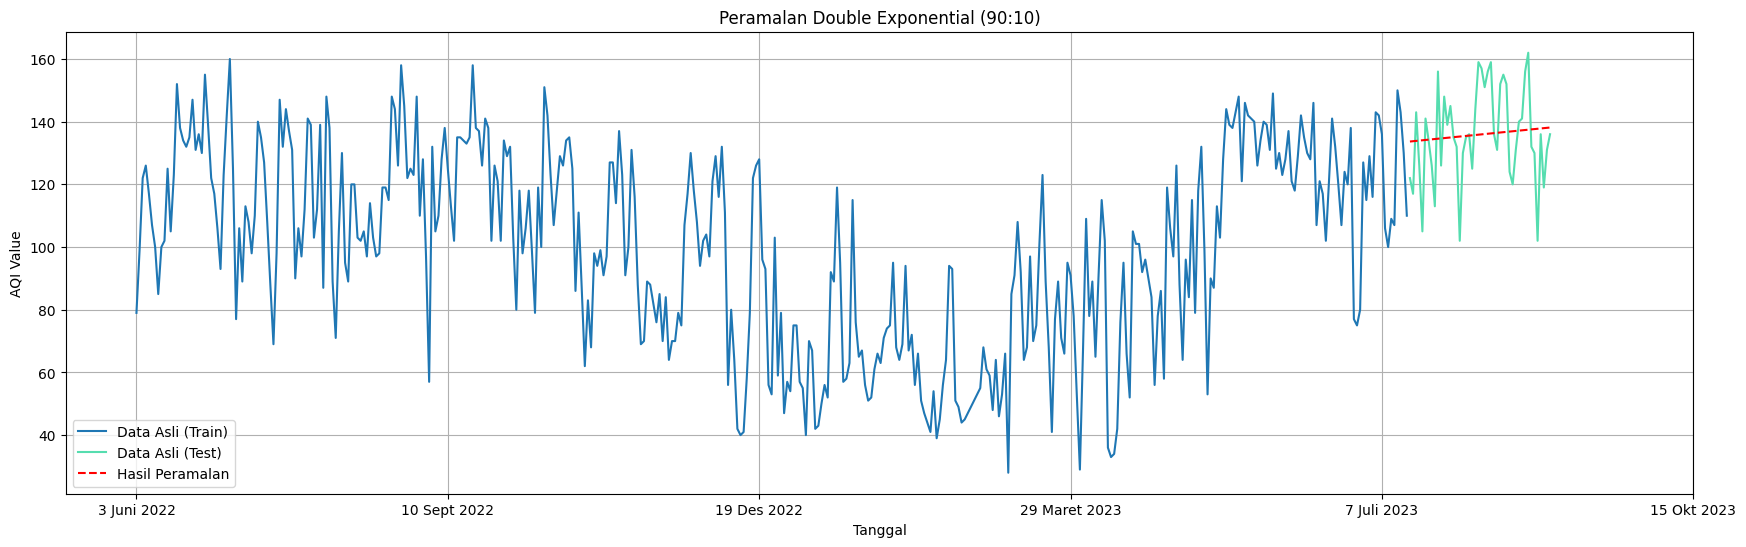

In [213]:
# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(21, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(train_db)], train_db_scaler, label='Data Asli (Train)')
plt.plot(df['Date'][-len(test_db):], test_db_scaler, label='Data Asli (Test)', color = '#55DDAF')
plt.plot(df['Date'][-len(test_db):], pred_scaler, label='Hasil Peramalan', color ='red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Double Exponential (90:10)')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

#Forecast

In [214]:
# Fungsi tujuan untuk optimasi PSO
def objective(params):
    alpha, beta = params

    model_holt = ExponentialSmoothing(df1, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt = model_holt.fit(smoothing_level=alpha, smoothing_trend=beta)
    pred_df1_holt = fit_holt.fittedvalues

    # Menghitung Mean Squared Error (MSE) sebagai fungsi tujuan
    mse = mean_squared_error(df1, pred_df1_holt)

    return mse

# Tentukan batas parameter untuk PSO
lb = [0.01, 0.01]  # Lower bounds for alpha and beta
ub = [0.99, 0.99]  # Upper bounds for alpha and beta

# Inisialisasi list untuk menyimpan nilai objektif, alpha, dan beta selama iterasi
iteration_results = []

# Jalankan PSO untuk mencari parameter terbaik
for i in tqdm(range(100)):  # Sesuaikan dengan jumlah iterasi yang diinginkan
    best_params, _ = pso(objective, lb, ub, swarmsize=10, maxiter=1)

    # Simpan hasil iterasi
    alpha_optimal, beta_optimal = best_params
    model_holt_optimal = ExponentialSmoothing(df1, trend='add', initialization_method='estimated', seasonal=None, damped_trend=False)
    fit_holt_optimal = model_holt_optimal.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
    df1_mse_score = mean_squared_error(df1, fit_holt_optimal.fittedvalues)

    iteration_results.append({
        'Iteration': i + 1,
        'Alpha': alpha_optimal,
        'Beta': beta_optimal,
        'df1_MSE': df1_mse_score
    })

# Tampilkan hasil iterasi
for result in iteration_results:
    print(result)

  2%|▏         | 2/100 [00:00<00:20,  4.82it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


  3%|▎         | 3/100 [00:00<00:18,  5.25it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


  6%|▌         | 6/100 [00:01<00:16,  5.87it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


  8%|▊         | 8/100 [00:01<00:14,  6.19it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 10%|█         | 10/100 [00:01<00:14,  6.14it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 12%|█▏        | 12/100 [00:02<00:13,  6.41it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 14%|█▍        | 14/100 [00:02<00:13,  6.25it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 15%|█▌        | 15/100 [00:02<00:14,  5.86it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 18%|█▊        | 18/100 [00:03<00:13,  6.15it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 20%|██        | 20/100 [00:03<00:12,  6.25it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 22%|██▏       | 22/100 [00:03<00:12,  6.24it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 24%|██▍       | 24/100 [00:04<00:12,  6.27it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 26%|██▌       | 26/100 [00:04<00:11,  6.22it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 28%|██▊       | 28/100 [00:04<00:11,  6.03it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 30%|███       | 30/100 [00:04<00:10,  6.52it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 32%|███▏      | 32/100 [00:05<00:10,  6.47it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 34%|███▍      | 34/100 [00:05<00:09,  6.70it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 36%|███▌      | 36/100 [00:05<00:09,  6.41it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 38%|███▊      | 38/100 [00:06<00:10,  6.01it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 40%|████      | 40/100 [00:06<00:10,  5.98it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 42%|████▏     | 42/100 [00:06<00:09,  6.10it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 43%|████▎     | 43/100 [00:07<00:11,  5.06it/s]

Stopping search: maximum iterations reached --> 1


 45%|████▌     | 45/100 [00:07<00:10,  5.24it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 47%|████▋     | 47/100 [00:07<00:08,  5.90it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 49%|████▉     | 49/100 [00:08<00:08,  6.07it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 51%|█████     | 51/100 [00:08<00:07,  6.18it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 53%|█████▎    | 53/100 [00:08<00:07,  6.41it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 55%|█████▌    | 55/100 [00:09<00:07,  6.31it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 57%|█████▋    | 57/100 [00:09<00:06,  6.22it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 59%|█████▉    | 59/100 [00:09<00:06,  6.30it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 61%|██████    | 61/100 [00:10<00:06,  6.42it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 63%|██████▎   | 63/100 [00:10<00:05,  6.47it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 65%|██████▌   | 65/100 [00:10<00:05,  6.43it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 67%|██████▋   | 67/100 [00:10<00:05,  6.42it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 69%|██████▉   | 69/100 [00:11<00:04,  6.23it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 71%|███████   | 71/100 [00:11<00:04,  5.90it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 73%|███████▎  | 73/100 [00:11<00:04,  6.28it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 75%|███████▌  | 75/100 [00:12<00:03,  6.32it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 77%|███████▋  | 77/100 [00:12<00:03,  6.30it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 79%|███████▉  | 79/100 [00:12<00:03,  6.26it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 81%|████████  | 81/100 [00:13<00:03,  6.14it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 83%|████████▎ | 83/100 [00:13<00:02,  6.08it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 84%|████████▍ | 84/100 [00:13<00:02,  6.24it/s]

Stopping search: maximum iterations reached --> 1


 85%|████████▌ | 85/100 [00:14<00:03,  4.54it/s]

Stopping search: maximum iterations reached --> 1


 86%|████████▌ | 86/100 [00:14<00:03,  4.58it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 88%|████████▊ | 88/100 [00:14<00:02,  4.56it/s]

Stopping search: maximum iterations reached --> 1


 89%|████████▉ | 89/100 [00:14<00:02,  4.59it/s]

Stopping search: maximum iterations reached --> 1


 90%|█████████ | 90/100 [00:15<00:02,  3.60it/s]

Stopping search: maximum iterations reached --> 1


 91%|█████████ | 91/100 [00:15<00:02,  3.79it/s]

Stopping search: maximum iterations reached --> 1


 92%|█████████▏| 92/100 [00:15<00:02,  3.85it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 95%|█████████▌| 95/100 [00:16<00:01,  4.37it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 97%|█████████▋| 97/100 [00:16<00:00,  5.05it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


 99%|█████████▉| 99/100 [00:17<00:00,  5.34it/s]

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]

Stopping search: maximum iterations reached --> 1
{'Iteration': 1, 'Alpha': 0.6283558249854128, 'Beta': 0.01, 'df1_MSE': 0.022789560524759472}
{'Iteration': 2, 'Alpha': 0.7889091876383794, 'Beta': 0.044595919240599975, 'df1_MSE': 0.02414077862070336}
{'Iteration': 3, 'Alpha': 0.3147318070997767, 'Beta': 0.08660711020309675, 'df1_MSE': 0.02487935977597462}
{'Iteration': 4, 'Alpha': 0.38987711291277566, 'Beta': 0.01, 'df1_MSE': 0.022847106881143785}
{'Iteration': 5, 'Alpha': 0.7209341300572465, 'Beta': 0.01, 'df1_MSE': 0.023075896001962554}
{'Iteration': 6, 'Alpha': 0.6507167391571111, 'Beta': 0.01, 'df1_MSE': 0.022842268818634773}
{'Iteration': 7, 'Alpha': 0.2739704610674456, 'Beta': 0.01, 'df1_MSE': 0.023332613602069213}
{'Iteration': 8, 'Alpha': 0.5138356561087984, 'Beta': 0.01, 'df1_MSE': 0.022675868258629845}
{'Iteration': 9, 'Alpha': 0.92739620851763, 'Beta': 0.01, 'df1_MSE': 0.024447617971140194}
{'Iteration': 10, 'Alpha': 0.46974495281225026, 'Beta': 0.01, 'df1_MSE': 0.0227007979

In [203]:
alpha_optimal, beta_optimal = best_params

double_exp_df = sm.ExponentialSmoothing(df1, trend='add', initialization_method='estimated', seasonal=None, seasonal_periods=30, damped_trend = False)
double_exp_df_fit = double_exp.fit(smoothing_level=alpha_optimal, smoothing_trend=beta_optimal)
double_exp_pred = double_exp_df_fit.forecast(30)

print("Alpha : ", round(smoothing_level_train, 5))
print("Beta : ", round(smoothing_trend_train, 5))

new_index = np.arange (len(df), len(df)+len(double_exp_pred))
new_index

Alpha :  0.39193
Beta :  0.68317


array([455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
       481, 482, 483, 484])

In [204]:
#Denormalisasi data untuk menghasilkan nilai yang aktual
df1_array = df1.values.reshape(-1, 1)
pred_array = double_exp_pred.values.reshape(-1, 1)

# Now you can use test_db_array in your scaler.inverse_transform call
df1_scaler = scaler.inverse_transform(df1_array)
double_exp_pred_scaler = scaler.inverse_transform(pred_array)

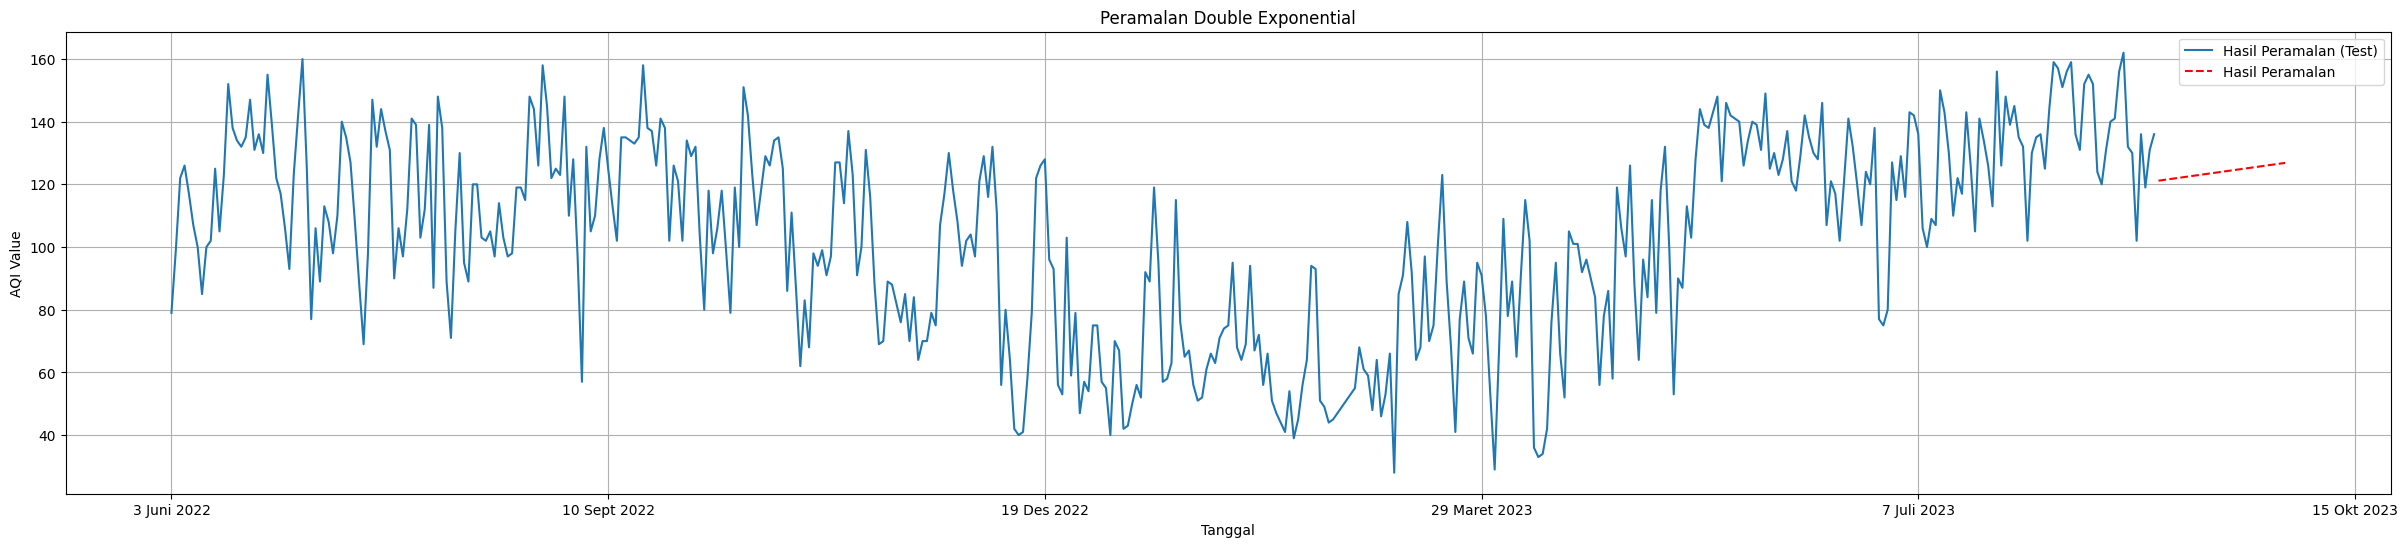

In [205]:
# Visualisasi hasil peramalan untuk data pelatihan dan pengujian dalam satu grafik
plt.figure(figsize=(30, 6))  # Ukuran gambar
plt.plot(df['Date'][:len(df1)], df1_scaler, label='Hasil Peramalan (Test)')
plt.plot(new_index, double_exp_pred_scaler, label='Hasil Peramalan', color ='red', linestyle='dashed')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Tanggal')
plt.ylabel('AQI Value')
plt.title('Peramalan Double Exponential')
x = [0, 100, 200, 300, 400, 500]  # Menambahkan indeks untuk tanggal prediksi
x_labels = ['3 Juni 2022', '10 Sept 2022', '19 Des 2022', '29 Maret 2023', '7 Juli 2023', '15 Okt 2023']  # Menambahkan label untuk tanggal prediksi
plt.xticks(x, x_labels)

plt.grid(True)
plt.legend()
plt.show()

In [206]:
# Save the model and its parameters
model_and_params = {
    'model': double_exp_df,
    'parameters': {
        'alpha': alpha_optimal,
        'beta': beta_optimal
    }
}

pickle.dump(model_and_params, open('DES_Model_Prediksi.sav', 'wb'))